# 6. Sistema de Control Difuso

- Autor: Rodrigo Salas, Dr. Ing.
- email: rodrigo.salas@uv.cl

En este notebook exploraremos el toolbox de SciKit-Fuzzy. Este documento está basado en la guía de usuario publicada:

https://pythonhosted.org/scikit-fuzzy/userguide/getting_started.html

Revisar la licencia de los códigos en:

https://pythonhosted.org/scikit-fuzzy/license.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

%matplotlib inline

Muchos sistemas de control difusos tienen la tarea de mantener una determinada variable cerca de un valor específico. Por ejemplo, la temperatura para un proceso químico industrial podría necesitar mantenerse relativamente constante. 

Para hacer esto, el sistema generalmente sabe dos cosas:

- El error o desviación del valor ideal.
- La forma en que está cambiando el error. Esta es la primera derivada matemática; lo llamaremos delta

A partir de estos dos valores podemos construir un sistema que actuará adecuadamente.

## 6.1. Preparación del Sistema de Control

In [3]:
universe = np.linspace(-2, 2, 5)

error = ctrl.Antecedent(universe, 'error')
delta = ctrl.Antecedent(universe, 'delta')
output = ctrl.Consequent(universe, 'output')

Creación de las variables linguísticas de forma automática con 5 niveles:

- nb: negative big
- ns: negative small
- ze: zero
- ps: positive small
- pb: positive big

In [4]:
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
delta.automf(names=names)
output.automf(names=names)

## 6.2. Definición de las reglas

In [5]:
rule0 = ctrl.Rule(antecedent=((error['nb'] & delta['nb']) |
                              (error['ns'] & delta['nb']) |
                              (error['nb'] & delta['ns'])),
                  consequent=output['nb'], label='rule nb')

rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
                              (error['nb'] & delta['ps']) |
                              (error['ns'] & delta['ns']) |
                              (error['ns'] & delta['ze']) |
                              (error['ze'] & delta['ns']) |
                              (error['ze'] & delta['nb']) |
                              (error['ps'] & delta['nb'])),
                  consequent=output['ns'], label='rule ns')

rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
                              (error['ns'] & delta['ps']) |
                              (error['ze'] & delta['ze']) |
                              (error['ps'] & delta['ns']) |
                              (error['pb'] & delta['nb'])),
                  consequent=output['ze'], label='rule ze')

rule3 = ctrl.Rule(antecedent=((error['ns'] & delta['pb']) |
                              (error['ze'] & delta['pb']) |
                              (error['ze'] & delta['ps']) |
                              (error['ps'] & delta['ps']) |
                              (error['ps'] & delta['ze']) |
                              (error['pb'] & delta['ze']) |
                              (error['pb'] & delta['ns'])),
                  consequent=output['ps'], label='rule ps')

rule4 = ctrl.Rule(antecedent=((error['ps'] & delta['pb']) |
                              (error['pb'] & delta['pb']) |
                              (error['pb'] & delta['ps'])),
                  consequent=output['pb'], label='rule pb')

## 6.3. Creación del sistema de control

In [6]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

# 6.4. Creador del Simulador

In [7]:
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

# Libera la memoria despues de 21x21 calculos

# 6.5. Cálculo de la superficie de control

In [8]:
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

for i in range(21):
    for j in range(21):
        sim.input['error'] = x[i, j]
        sim.input['delta'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['output']

# 6.6. Visualización de la superficie de control de la simulación

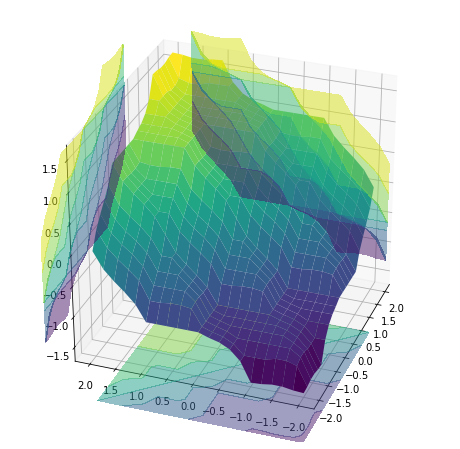

In [9]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)